# Qubit Control

In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import qutip as qt
import qctrlvisualizer as qv


class Simulator:
    def __init__(
        self,
        sampling_period: float,
        dimension: int,
        frequency: float,
        anharmonicity: float,
    ):
        self.sampling_period = sampling_period
        self.dimension = dimension
        self.frequency = frequency
        self.anharmonicity = anharmonicity

    def simulate(self, waveform: npt.NDArray[np.complex128]):
        samples = np.array(waveform, dtype=np.complex128)
        samples = np.append(samples, samples[-1])
        n_samples = len(samples)
        duraiton = (n_samples - 1) * self.sampling_period
        times = np.linspace(0.0, duraiton, n_samples)
        omega = 2 * np.pi * self.frequency
        alpha = 2 * np.pi * self.anharmonicity
        a = qt.destroy(self.dimension)
        ad = a.dag()
        hamiltonian = []
        hamiltonian.append(omega * ad * a)
        hamiltonian.append(0.5 * alpha * ad * ad * a * a)
        hamiltonian.append([0.5 * a, samples])
        hamiltonian.append([0.5 * ad, np.conj(samples)])
        initial_state = qt.basis(self.dimension, 0)
        result = qt.mesolve(
            hamiltonian,
            initial_state,
            times,
        )
        return result

    def plot_waveform(self, waveform: npt.NDArray[np.complex128]):
        samples = np.array(waveform, dtype=np.complex128)
        samples = np.append(samples, samples[-1])
        n_samples = len(samples)
        duraiton = (n_samples - 1) * self.sampling_period
        times = np.linspace(0.0, duraiton, n_samples)
        plt.step(times, np.real(samples), label="I", where="post")
        plt.step(times, np.imag(samples), label="Q", where="post")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

    def display_bloch_sphere(self, result):
        states = np.array(result.states).squeeze()
        qv.display_bloch_sphere(states[:, :2])

    def plot_populations(self, result):
        states = np.array(result.states).squeeze()
        populations = np.abs(states) ** 2
        qv.plot_population_dynamics(
            sample_times=result.times,
            populations={
                rf"$|{k}\rangle$": populations[:, k] for k in range(self.dimension)
            },
        )

    def rect_pulse(
        self,
        duration: float,
        amplitude: float,
    ) -> npt.NDArray[np.complex128]:
        length = int(duration / self.sampling_period)
        t = np.linspace(0.0, duration, length)
        values = amplitude * np.ones_like(t, dtype=np.complex128)
        return values

    def gaussian_pulse(
        self,
        duration: float,
        amplitude: float,
    ) -> npt.NDArray[np.complex128]:
        length = int(duration / self.sampling_period)
        t = np.linspace(0.0, duration, length)
        sigma = duration / 6
        mu = duration / 2
        values = np.exp(-((t - mu) ** 2) / sigma**2)
        values = values / (np.sum(values) * self.sampling_period)
        values = amplitude * values
        return values

    def drag_pulse(
        self,
        duration: float,
        amplitude: float,
    ) -> npt.NDArray[np.complex128]:
        length = int(duration / self.sampling_period)
        t = np.linspace(0.0, duration, length)
        sigma = duration / 6
        mu = duration / 2
        real = np.exp(-((t - mu) ** 2) / sigma**2)
        real = real / (np.sum(real) * self.sampling_period)
        real = amplitude * real
        alpha = 2 * np.pi * self.anharmonicity
        beta = 1 / alpha
        imag = beta * (mu - t) / sigma**2 * real
        return real + 1j * imag

In [2]:
simulator = Simulator(
    sampling_period=0.5,
    dimension=3,
    frequency=0,
    anharmonicity=-0.3,
)

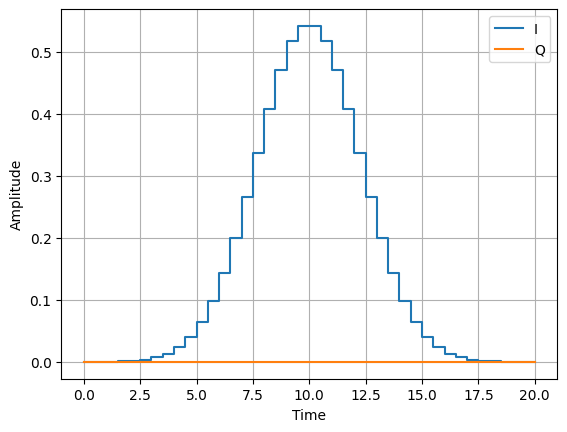

In [3]:
gauss = simulator.gaussian_pulse(
    duration=20,
    amplitude=np.pi,
)
simulator.plot_waveform(gauss)

<IPython.core.display.Javascript object>

0.9853210763922742


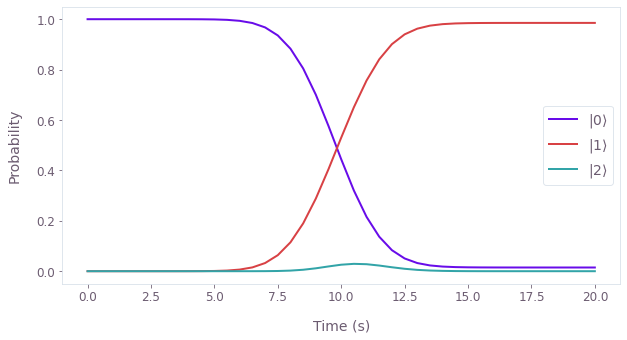

In [4]:
result_gauss = simulator.simulate(gauss)
simulator.display_bloch_sphere(result_gauss)
simulator.plot_populations(result_gauss)
states = np.array(result_gauss.states).squeeze()
populations = np.abs(states) ** 2
print(populations[-1][1])

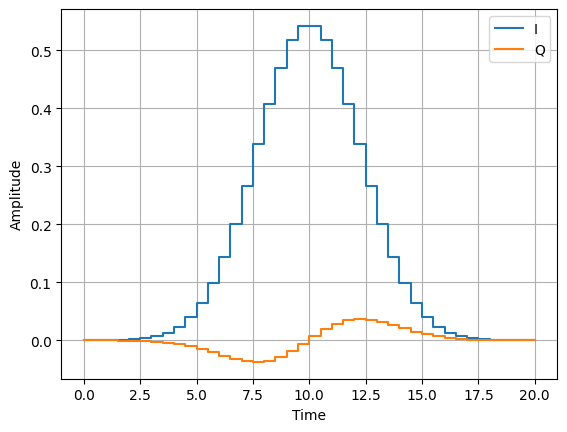

In [5]:
drag = simulator.drag_pulse(
    duration=20,
    amplitude=np.pi,
)
simulator.plot_waveform(drag)

<IPython.core.display.Javascript object>

0.9999098164579641


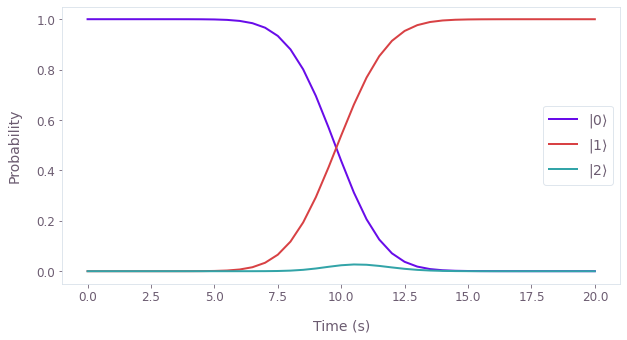

In [6]:
result_drag = simulator.simulate(drag)
simulator.display_bloch_sphere(result_drag)
simulator.plot_populations(result_drag)
states = np.array(result_drag.states).squeeze()
populations = np.abs(states) ** 2
print(populations[-1][1])